## Data loading and initial processing

### Subtask:
Load the dataset and perform initial data cleaning, including handling missing values.


**Reasoning**:
The first step is to load the data from the specified CSV file into a pandas DataFrame, rename the relevant column, and then display the head and info of the DataFrame to understand its structure and data types.



In [1]:
import pandas as pd


df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv")
df = df.rename(columns={"Daily minimum temperatures": "Value"})
display(df.head())
display(df.info())

,Date,Value
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Value   3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


None

## Stationarity

### Subtask:
Apply differencing to make the time series stationary and visualize both the original and stationary series.


**Reasoning**:
Plot the original and stationary time series to visualize the effect of differencing.



**Reasoning**:
We will use the `make_stationary` function (defined in the data processing section) to apply differencing and make the time series stationary. Then, plot the original and stationary time series to visualize the effect of differencing.

/tmp/ipython-input-1169631425.py:82: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(stationary, regression="c", nlags="auto")


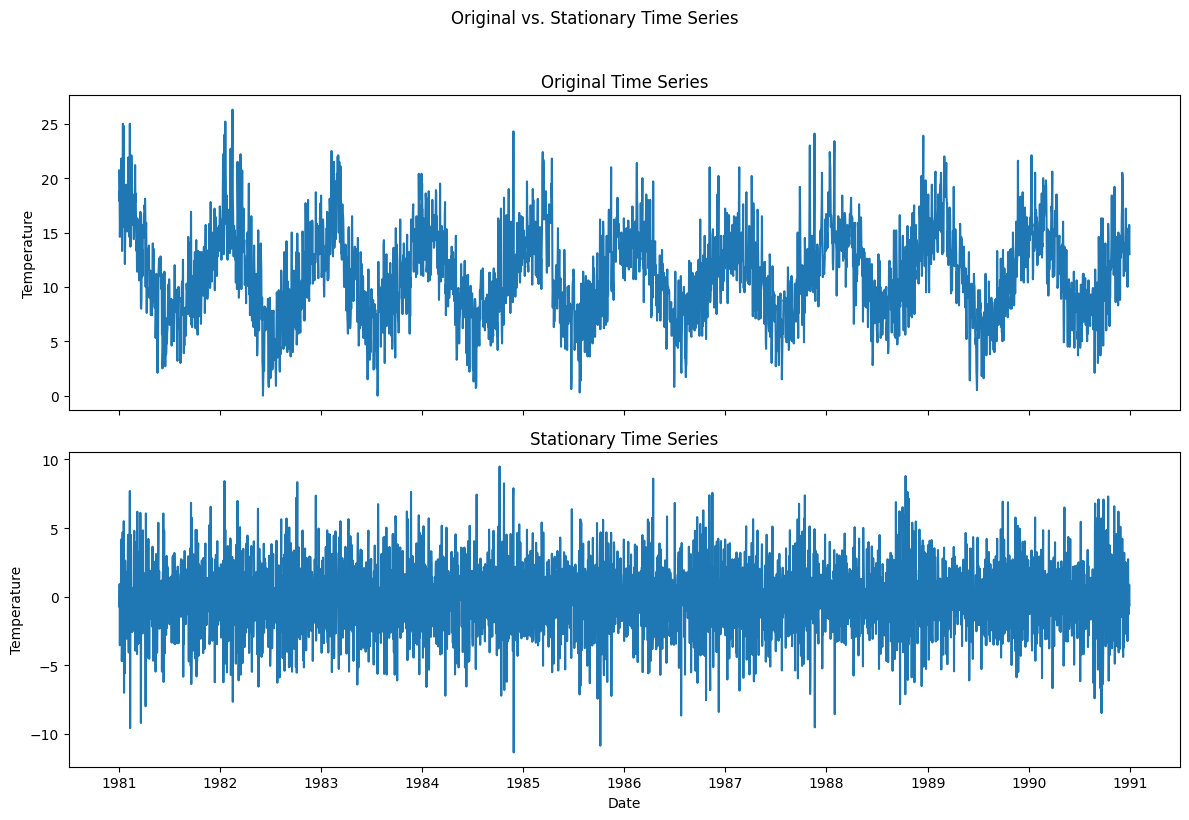

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Redefining necessary functions and ProcessingConfig to ensure they are available
def compute_acf_pacf(s: pd.Series, lags: int = 40) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a time series.

    Args:
        s: The input time series.
        lags: The number of lags to compute the ACF and PACF for.

    Returns:
        A tuple containing the ACF values and PACF values.
    """
    s_clean = s.dropna()
    return acf(s_clean, nlags=lags, fft=True), pacf(s_clean, nlags=lags, method="yw") # Changed method to "yw"

def make_stationary(
    s: pd.Series, cfg: 'ProcessingConfig'
) -> Tuple[pd.Series, int, Dict[str, Any]]:
    """
    Make a time series stationary using differencing and test for stationarity.

    Args:
        s: The input time series.
        cfg: The processing configuration.

    Returns:
        A tuple containing the stationary time series, the differencing order,
        and a dictionary of stationarity test results.
    """
    tests = {}
    s_clean = s.dropna()

    # ADF Test
    adf_test = adfuller(s_clean)
    tests["adf"] = {
        "statistic": adf_test[0],
        "p_value": adf_test[1],
        "critical_values": adf_test[4],
        "is_stationary": adf_test[1] <= 0.05,
    }

    # KPSS Test
    kpss_test = kpss(s_clean, regression="c", nlags="auto")
    tests["kpss"] = {
        "statistic": kpss_test[0],
        "p_value": kpss_test[1],
        "critical_values": kpss_test[3],
        "is_stationary": kpss_test[1] > 0.05,
    }

    if tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]:
        return s, 0, tests
    else:
        # Apply differencing
        d = 0
        stationary = s.copy()
        while not (tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]):
            d += 1
            stationary = stationary.diff().dropna()
            if stationary.empty or d > cfg.max_d:  # Avoid infinite loops and handle empty series
              break

            if len(stationary) > 8: # ADF/KPSS require at least 8 data points
                adf_test = adfuller(stationary)
                tests["adf"] = {
                    "statistic": adf_test[0],
                    "p_value": adf_test[1],
                    "critical_values": adf_test[4],
                    "is_stationary": adf_test[1] <= 0.05,
                }

                kpss_test = kpss(stationary, regression="c", nlags="auto")
                tests["kpss"] = {
                    "statistic": kpss_test[0],
                    "p_value": kpss_test[1],
                    "critical_values": kpss_test[3],
                    "is_stationary": kpss_test[1] > 0.05,
                }
            else: # Consider not stationary if not enough data after differencing
                 tests["adf"]["is_stationary"] = False
                 tests["kpss"]["is_stationary"] = False


        return stationary, d, tests

def train_test_split_series(
    s: pd.Series, test_size: float = 0.2
) -> Tuple[pd.Series, pd.Series]:
    """
    Split a time series into training and testing sets.

    Args:
        s: The input time series.
        test_size: The proportion of the data to include in the test split.

    Returns:
        A tuple containing the training and testing sets.
    """
    train_size = int(len(s) * (1 - test_size))
    train, test = s[0:train_size], s[train_size:]
    return train, test


class ProcessingConfig:
    """Configuration for time series processing."""

    def __init__(
        self,
        date_col: str = "Date",
        value_col: str = "Value",
        expected_freq: str = "D",
        seasonal_period: int = 12,
        acf_pacf_lags: int = 40,
        test_size: float = 0.2,
        max_d: int = 2 # Maximum differencing order
    ):
        self.date_col = date_col
        self.value_col = value_col
        self.expected_freq = expected_freq
        self.seasonal_period = seasonal_period
        self.acf_pacf_lags = acf_pacf_lags
        self.test_size = test_size
        self.max_d = max_d


def process_time_series(csv_path: str, cfg: ProcessingConfig) -> Dict[str, Any]:
    """
    Load, preprocess, and analyze a time series from a CSV file.

    Args:
        csv_path: The path to the CSV file.
        cfg: The processing configuration.

    Returns:
        A dictionary containing the processing results.
    """
    df = pd.read_csv(csv_path)

    # Ensure value column is numeric
    df[cfg.value_col] = pd.to_numeric(df[cfg.value_col], errors='coerce')
    df.dropna(subset=[cfg.value_col], inplace=True)

    # Convert date column to datetime and set as index
    df[cfg.date_col] = pd.to_datetime(df[cfg.date_col])
    df.set_index(cfg.date_col, inplace=True)

    # Ensure expected frequency
    s = df[cfg.value_col].squeeze()
    s = s.asfreq(cfg.expected_freq)
    s = s.interpolate(method='time') # Interpolate missing values after setting frequency

    # Decompose time series
    decomp = seasonal_decompose(s, model="additive", period=cfg.seasonal_period)

    # Make stationary
    s_deseason = (s - decomp.seasonal).dropna()
    stationary_s, d, tests = make_stationary(s_deseason, cfg)

    # Compute ACF and PACF
    acf_vals, pacf_vals = compute_acf_pacf(stationary_s, lags=cfg.acf_pacf_lags)

    # Split data
    train_s, test_s = train_test_split_series(s, cfg.test_size)

    return {
        "original_series": s,
        "decomposition": decomp,
        "stationarity_tests": tests,
        "differencing_order": d,
        "stationary_series": stationary_s,
        "acf_values": acf_vals,
        "pacf_values": pacf_vals,
        "train_series": train_s,
        "test_series": test_s,
    }


# Call the redefined process_time_series function to create the 'out' dictionary
cfg = ProcessingConfig(expected_freq="D", seasonal_period=365, value_col="Daily minimum temperatures", date_col="Date")
out = process_time_series("/content/daily-minimum-temperatures-in-me.csv", cfg)

# Access original_series and stationary_series from the 'out' dictionary for plotting
original_series = out["original_series"]
stationary_series = out["stationary_series"]

# Regenerated plotting code from cell 47aa904c
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(original_series)
ax1.set_title("Original Time Series")
ax1.set_ylabel("Temperature")

ax2.plot(stationary_series)
ax2.set_title("Stationary Time Series")
ax2.set_xlabel("Date")
ax2.set_ylabel("Temperature")

plt.suptitle("Original vs. Stationary Time Series", y=1.02)
plt.tight_layout()
plt.show()

## Time series decomposition

### Subtask:
Decompose the time series into trend, seasonal, and residual components and analyze whether the series is additive or multiplicative. Visualize the trend and seasonality.

Analysis of Time Series Decomposition:
--------------------------------------
+ Observed Series: This is the original time series data.


+ Trend Component: Represents the underlying long-term progression of the series. Observe if there is an upward or downward slope indicating a trend.

+ Seasonal Component: Shows the repeating patterns or cycles that occur at fixed intervals (e.g., daily, weekly, yearly). Observe the regularity and magnitude of these patterns.

+ Residual Component: Represents the random or irregular component of the series after removing the trend and seasonality. Ideally, this should look like white noise (random fluctuations).

+ Assessing Additive vs. Multiplicative Decomposition:
Based on the visual characteristics of the seasonal component in relation to the trend, determine if an additive or multiplicative model is more appropriate.


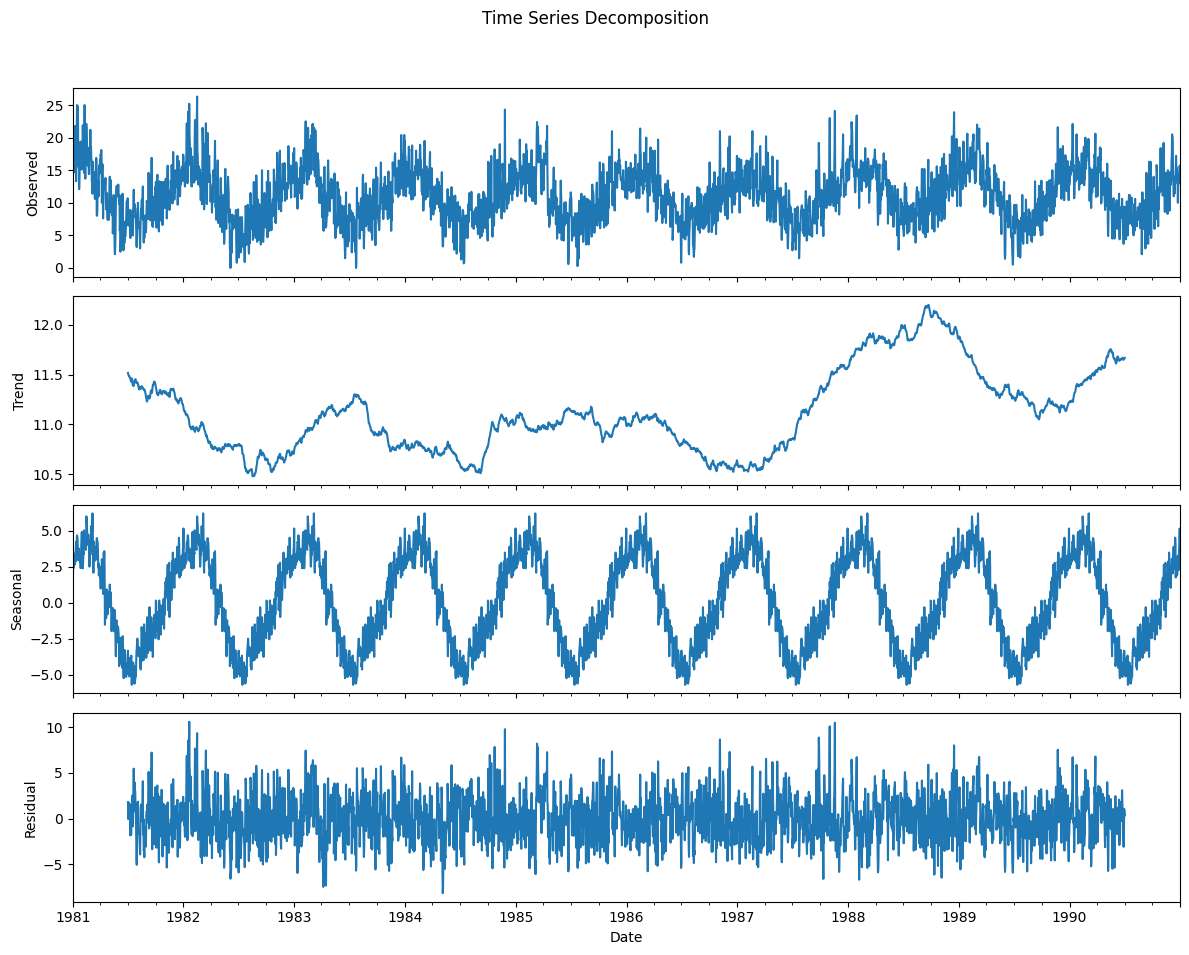

In [3]:
# Assuming 'out' from the previous processing step is available
decomp = out["decomposition"]

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomp.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")
decomp.trend.plot(ax=ax2)
ax2.set_ylabel("Trend")
decomp.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")
decomp.resid.plot(ax=ax4)
ax4.set_ylabel("Residual")
plt.suptitle("Time Series Decomposition")
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Predictive modeling

### Subtask:
Build and evaluate Autoregressive (AR) , Moving Average (MA) and SARIMA models for time series forecasting and visualize the results.

In [4]:
!pip install statsmodels

In [5]:
!pip install pmdarima

In [6]:
from pmdarima import auto_arima

test_s = out["test_series"]
train_s = out["train_series"]

# auto_arima cerca i migliori p,d,q
stepwise_model = auto_arima(train_s,
                            start_p=1, start_q=1,
                            max_p=2, max_q=2,  # Modelli da testare
                            m=12,              # periodicità stagionale (12 = mensile)
                            start_P=0, seasonal=True,
                            d=None, D=1,       # differenziazioni automatiche
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=36.80 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=16249.897, Time=0.21 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=14668.459, Time=3.71 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=14424.879, Time=3.45 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,0)[12]             : AIC=16247.924, Time=0.26 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=15472.525, Time=2.27 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=14421.687, Time=5.88 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=14750.642, Time=3.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=14419.776, Time=12.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=14525.758, Time=11.68 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=14413.047, Time=36.54 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=14415.991, Time=30.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=15332.228, Time=37.52 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=70.99 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,1,2)[12] intercept   : AIC=14254.581, Time=52.96 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,2)[12] intercept   : AIC=14253.568, Time=48.71 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,2)[12] intercept   : AIC=14252.224, Time=18.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=14251.219, Time=6.78 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=15392.642, Time=1.63 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=14252.274, Time=8.17 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=14658.821, Time=6.01 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=37.48 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12]             : AIC=14249.435, Time=2.05 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,0)[12]             : AIC=15390.659, Time=0.75 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,1)[12]             : AIC=14250.481, Time=3.27 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,2)[12]             : AIC=14250.430, Time=7.92 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,0)[12]             : AIC=14656.852, Time=2.18 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,1,2)[12]             : AIC=14251.765, Time=17.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AIC=14423.096, Time=1.27 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12]             : AIC=inf, Time=27.76 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12]             : AIC=inf, Time=10.93 sec

Best model:  ARIMA(0,0,2)(0,1,1)[12]          
Total fit time: 509.235 seconds


In [11]:
forecast_auto = stepwise_model.predict(n_periods=len(test_s))
forecast_auto = pd.Series(forecast_auto, index=test_s.index)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [12]:
print(stepwise_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2921
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -7120.718
Date:                              Sat, 13 Sep 2025   AIC                          14249.435
Time:                                      10:24:17   BIC                          14273.337
Sample:                                  01-01-1981   HQIC                         14258.046
                                       - 12-30-1988                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6265      0.017     37.429      0.000       0.594       0.659
ma.L2          0.23

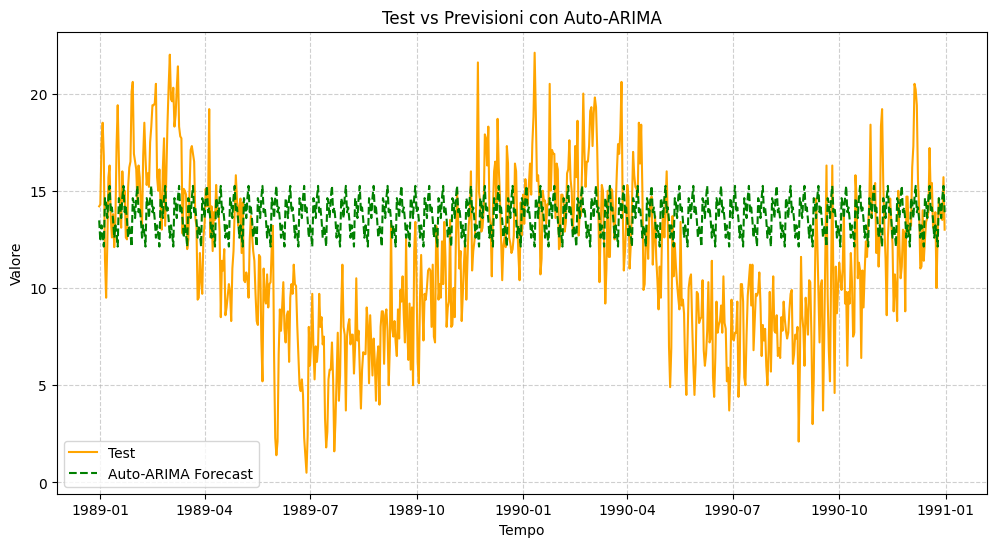

In [13]:
plt.figure(figsize=(12,6))
plt.plot(test_s, label="Test", color="orange")
plt.plot(forecast_auto, label="Auto-ARIMA Forecast", color="green", linestyle="--")
plt.title("Test vs Previsioni con Auto-ARIMA")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcolo metriche
mae = mean_absolute_error(test_s, forecast_auto)
rmse = np.sqrt(mean_squared_error(test_s, forecast_auto))

print("Auto-ARIMA -> MAE:", round(mae, 3))
print("Auto-ARIMA -> RMSE:", round(rmse, 3))

Auto-ARIMA -> MAE: 3.838
Auto-ARIMA -> RMSE: 4.74
